In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

In [3]:
# RMSPE 계산 함수
def rmspe(y_true, y_pred):
    return  np.sqrt(np.mean(np.square((y_true - y_pred) / (y_true))))

# LightGBM에서 사용할 수 있는 형태의 RMSPE 평가 함수
def rmspe_lgb(y_pred, data):
    y_true = data.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [4]:
df = pd.read_csv('/btc_selected_df_1.csv')
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.shape

(66696, 129)

In [5]:
def plot_range_lgbm(start, end):
  x_range = range(len(y_test[start:end]))

  plt.figure(figsize=(14,7))

  plt.plot(x_range, y_test[start:end], label='True', color='blue')
  plt.plot(x_range, y_pred[start:end], label='Predictions', color='red', linestyle='--')

  plt.title('True volatility vs Prediction volatility')
  plt.legend()
  plt.xlabel('Data Point Index')
  plt.ylabel('volatility')
  plt.show()

In [8]:
params = {
    'objective': 'regression',  # 회귀 문제
    'boosting_type': 'gbdt',    # Gradient Boosting Decision Tree
    'metric': 'l2',             # Mean Squared Error
    'num_leaves': 100,          # 리프 노드의 최대 수 (mean_leaves에 가깝게 설정)
    'min_data_in_leaf': 50,     # 한 리프에 최소한으로 필요한 레코드 수
    'max_depth': 15,            # 최대 깊이 (max_depth에 맞춤)
    'learning_rate': 0.05,      # 학습률
    'feature_fraction': 0.9,    # 트리를 학습할 때마다 선택할 피처의 비율
    'bagging_fraction': 0.8,    # 트리를 학습할 때마다 선택할 데이터의 비율
    'bagging_freq': 5,          # bagging의 빈도
    'n_estimators': 105         # 총 트리의 수 (number_of_trees에 맞춤)
}

# 가중치 X

## 일반적예측

In [12]:
X_train = df[:50000].drop('dv5_realized_volatility_mean0', axis=1)
y_train = df[:50000]['dv5_realized_volatility_mean0']

X_test = df[50000:].drop('dv5_realized_volatility_mean0', axis=1)
y_test = df[50000:]['dv5_realized_volatility_mean0']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, shuffle = False)

# LightGBM 데이터셋으로 변환
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val)

In [13]:
print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval
                )

# 모델 예측
print('Starting predicting...')
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# y_test = abs(y_test)
# y_pred = abs(y_pred)

# 모델 평가
print('The RMSPE of prediction is:', rmspe(y_test, y_pred))

Starting training...


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32633
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 128
[LightGBM] [Info] Start training from score 0.000177
Starting predicting...
The RMSPE of prediction is: 0.3767098150991803


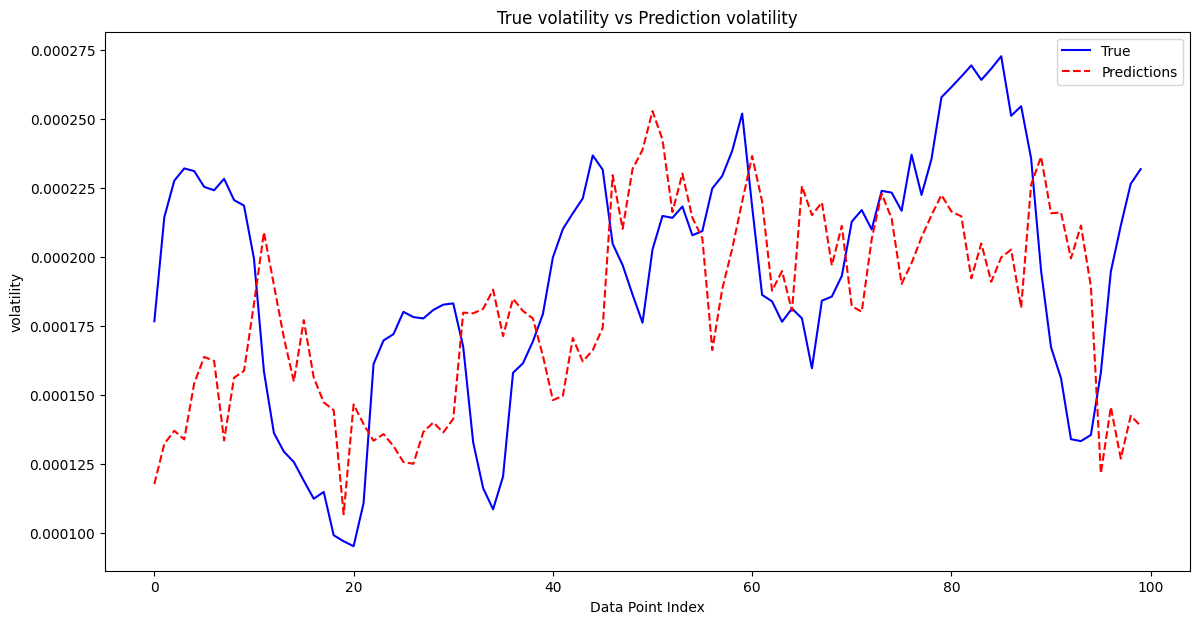

In [14]:
plot_range_lgbm(0,100)

# High value 예측

In [6]:
# 상위 5%에 해당하는 임계값 계산
threshold = df[50000:]['dv5_realized_volatility_mean0'].quantile(0.95)

# 임계값보다 큰 값만 추출
top_5_percent = df[50000:][df[50000:]['dv5_realized_volatility_mean0'] > threshold]

In [7]:
X_train = df[:50000].drop('dv5_realized_volatility_mean0', axis=1)
y_train = df[:50000]['dv5_realized_volatility_mean0']

X_test = top_5_percent.drop('dv5_realized_volatility_mean0', axis=1)
y_test = top_5_percent['dv5_realized_volatility_mean0']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, shuffle = False)

# LightGBM 데이터셋으로 변환
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val)

In [9]:
print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval
                )

# 모델 예측
print('Starting predicting...')
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# y_test = abs(y_test)
# y_pred = abs(y_pred)

# 모델 평가
print('The RMSPE of prediction is:', rmspe(y_test, y_pred))

Starting training...


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32633
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 128
[LightGBM] [Info] Start training from score 0.000177
Starting predicting...
The RMSPE of prediction is: 0.379834561176184


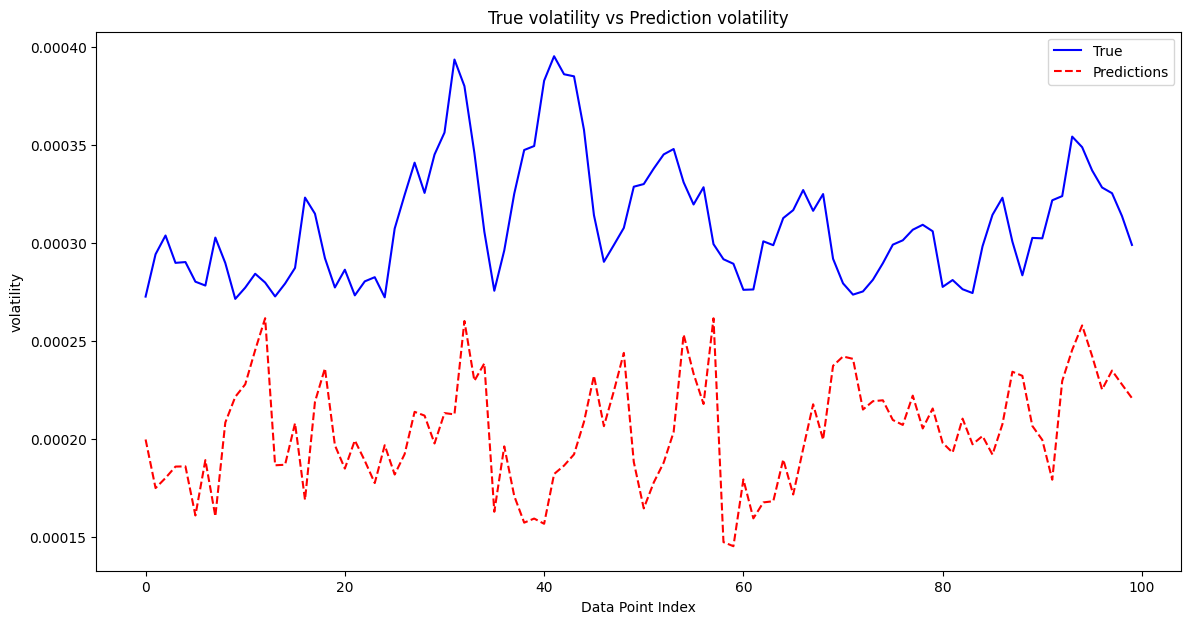

In [ ]:
plot_range_lgbm(0,100)

# 가중치 부여

## 일반적 예측

In [15]:
mask = df[:50000]['dv5_realized_volatility_mean0'] > df[:50000]['dv5_realized_volatility_mean0'].mean() + 1.5 * df[:50000]['dv5_realized_volatility_mean0'].std()
df[:50000].loc[mask, 'dv5_realized_volatility_mean0'] += df[:50000]['dv5_realized_volatility_mean0'].mean()


In [16]:
# 상위 5%에 해당하는 임계값 계산
threshold = df[50000:]['dv5_realized_volatility_mean0'].quantile(0.95)

# 임계값보다 큰 값만 추출
top_5_percent = df[50000:][df[50000:]['dv5_realized_volatility_mean0'] > threshold]

In [18]:
X_train = df[:50000].drop('dv5_realized_volatility_mean0', axis=1)
y_train = df[:50000]['dv5_realized_volatility_mean0']

X_test = df[50000:].drop('dv5_realized_volatility_mean0', axis=1)
y_test = df[50000:]['dv5_realized_volatility_mean0']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, shuffle = False)

# LightGBM 데이터셋으로 변환
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_val, y_val)

In [19]:
print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval
                )

# 모델 예측
print('Starting predicting...')
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# y_test = abs(y_test)
# y_pred = abs(y_pred)

# 모델 평가
print('The RMSPE of prediction is:', rmspe(y_test, y_pred))

Starting training...


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.056277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32633
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 128
[LightGBM] [Info] Start training from score 0.000191
Starting predicting...
The RMSPE of prediction is: 0.4071203906799332


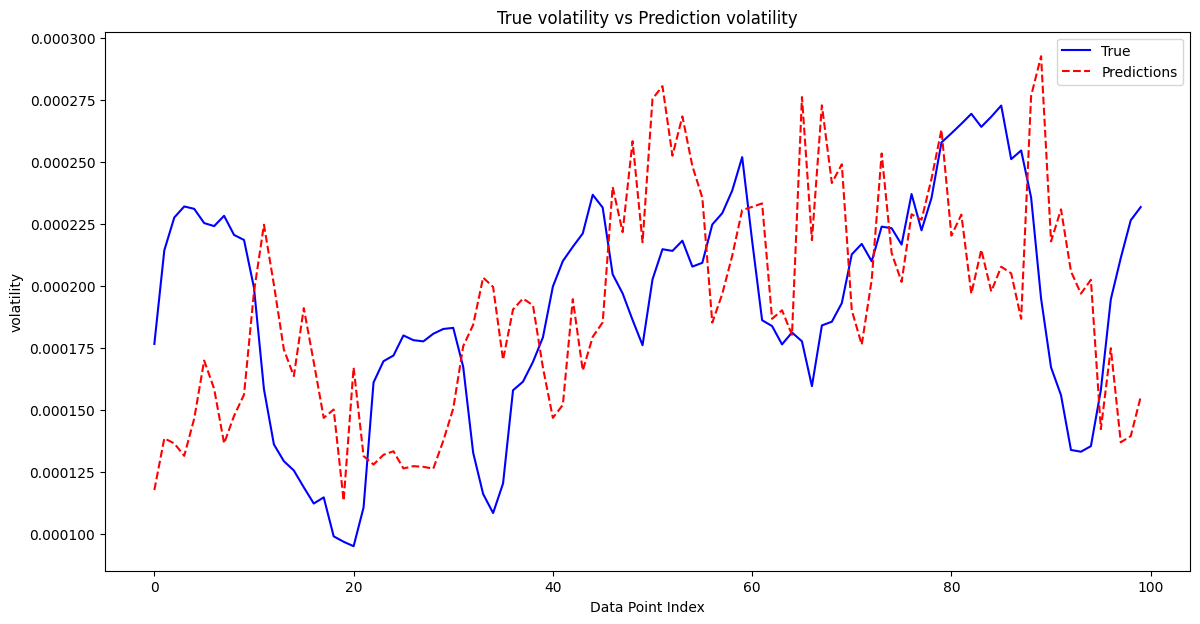

In [20]:
plot_range_lgbm(0,100)

## 하이밸류 예측

In [21]:
X_train = df[:50000].drop('dv5_realized_volatility_mean0', axis = 1)
y_train = df[:50000]['dv5_realized_volatility_mean0']

X_test = top_5_percent.drop('dv5_realized_volatility_mean0', axis = 1)
y_test = top_5_percent['dv5_realized_volatility_mean0']

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, shuffle = False)

# # LightGBM 데이터셋으로 변환
# lgb_train = lgb.Dataset(X_train, y_train)
# lgb_eval = lgb.Dataset(X_val, y_val)

In [22]:
print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval
                )

# 모델 예측
print('Starting predicting...')
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# y_test = abs(y_test)
# y_pred = abs(y_pred)

# 모델 평가
print('The RMSPE of prediction is:', rmspe(y_test, y_pred))

Starting training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.074193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32633
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 128
[LightGBM] [Info] Start training from score 0.000191


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Starting predicting...
The RMSPE of prediction is: 0.344795112978763


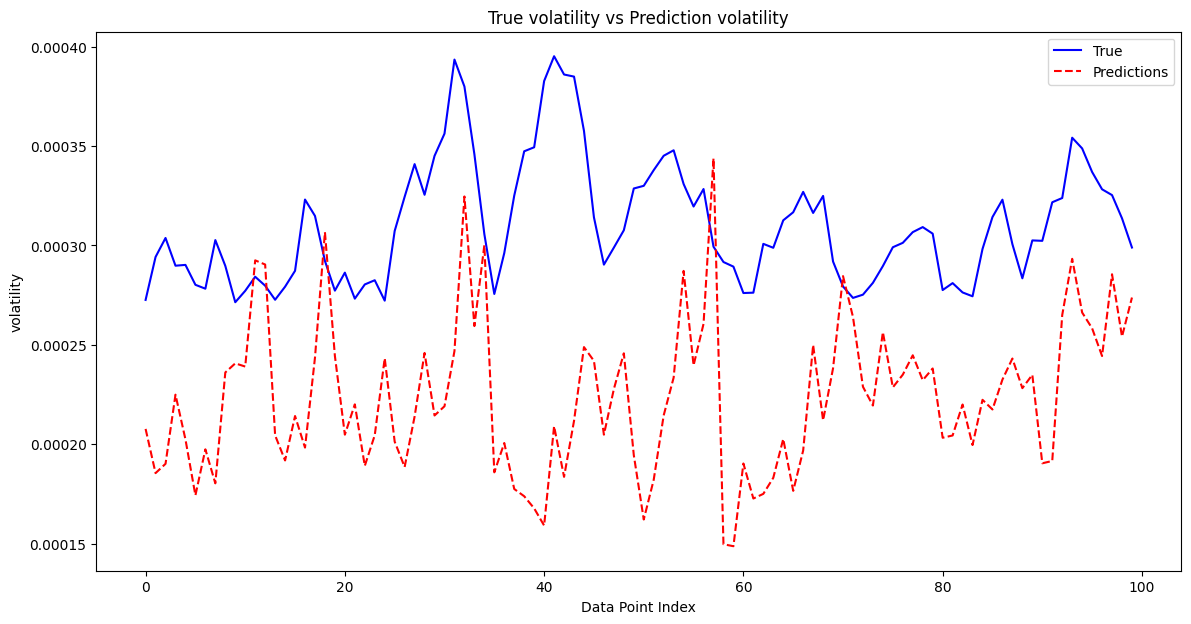

In [23]:
plot_range_lgbm(0,100)

In [ ]:
X_test = top_5_percent.drop('dv5_realized_volatility_mean0', axis = 1)
y_test = top_5_percent['dv5_realized_volatility_mean0']

print('Starting training...')
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval
                )

# 모델 예측
print('Starting predicting...')
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# y_test = abs(y_test)
# y_pred = abs(y_pred)

# 모델 평가
print('The RMSPE of prediction is:', rmspe(y_test, y_pred))

Starting training...
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.061305 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32633
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 128
[LightGBM] [Info] Start training from score 0.000177


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Starting predicting...
The RMSPE of prediction is: 0.3825399899027892


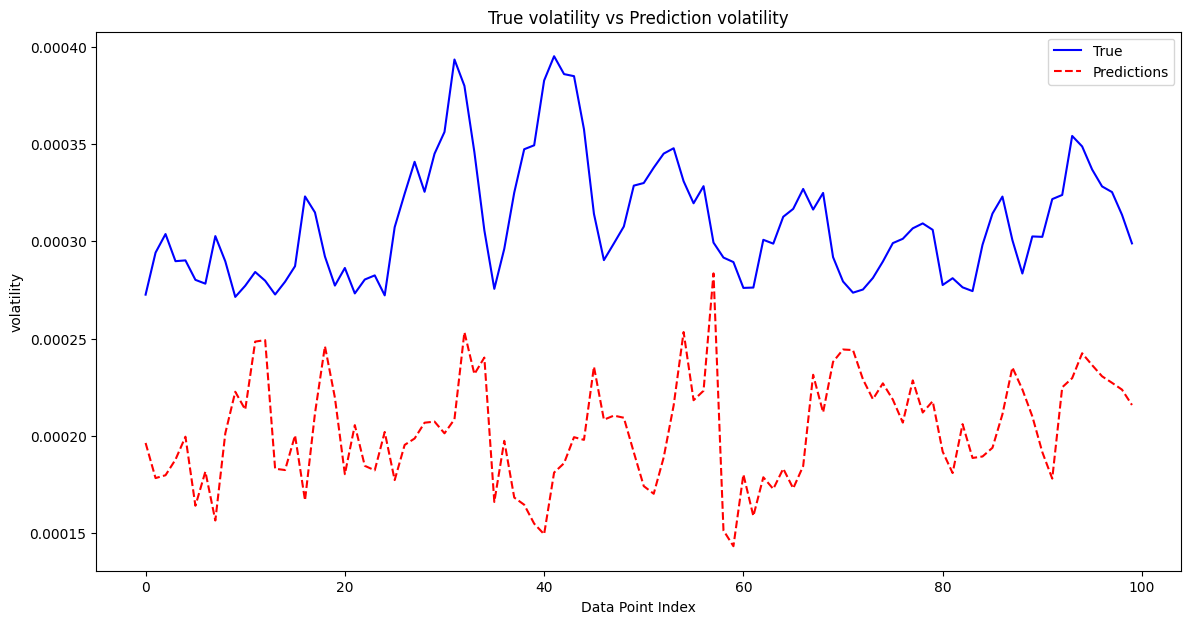

In [ ]:
plot_range_lgbm(0,100)